In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

# Other utilities
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/sales_and_customer_insights.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               10000 non-null  object 
 1   Product_ID                10000 non-null  object 
 2   Transaction_ID            10000 non-null  object 
 3   Purchase_Frequency        10000 non-null  int64  
 4   Average_Order_Value       10000 non-null  float64
 5   Most_Frequent_Category    10000 non-null  object 
 6   Time_Between_Purchases    10000 non-null  int64  
 7   Region                    10000 non-null  object 
 8   Churn_Probability         10000 non-null  float64
 9   Lifetime_Value            10000 non-null  float64
 10  Launch_Date               10000 non-null  object 
 11  Peak_Sales_Date           10000 non-null  object 
 12  Season                    10000 non-null  object 
 13  Preferred_Purchase_Times  10000 non-null  object

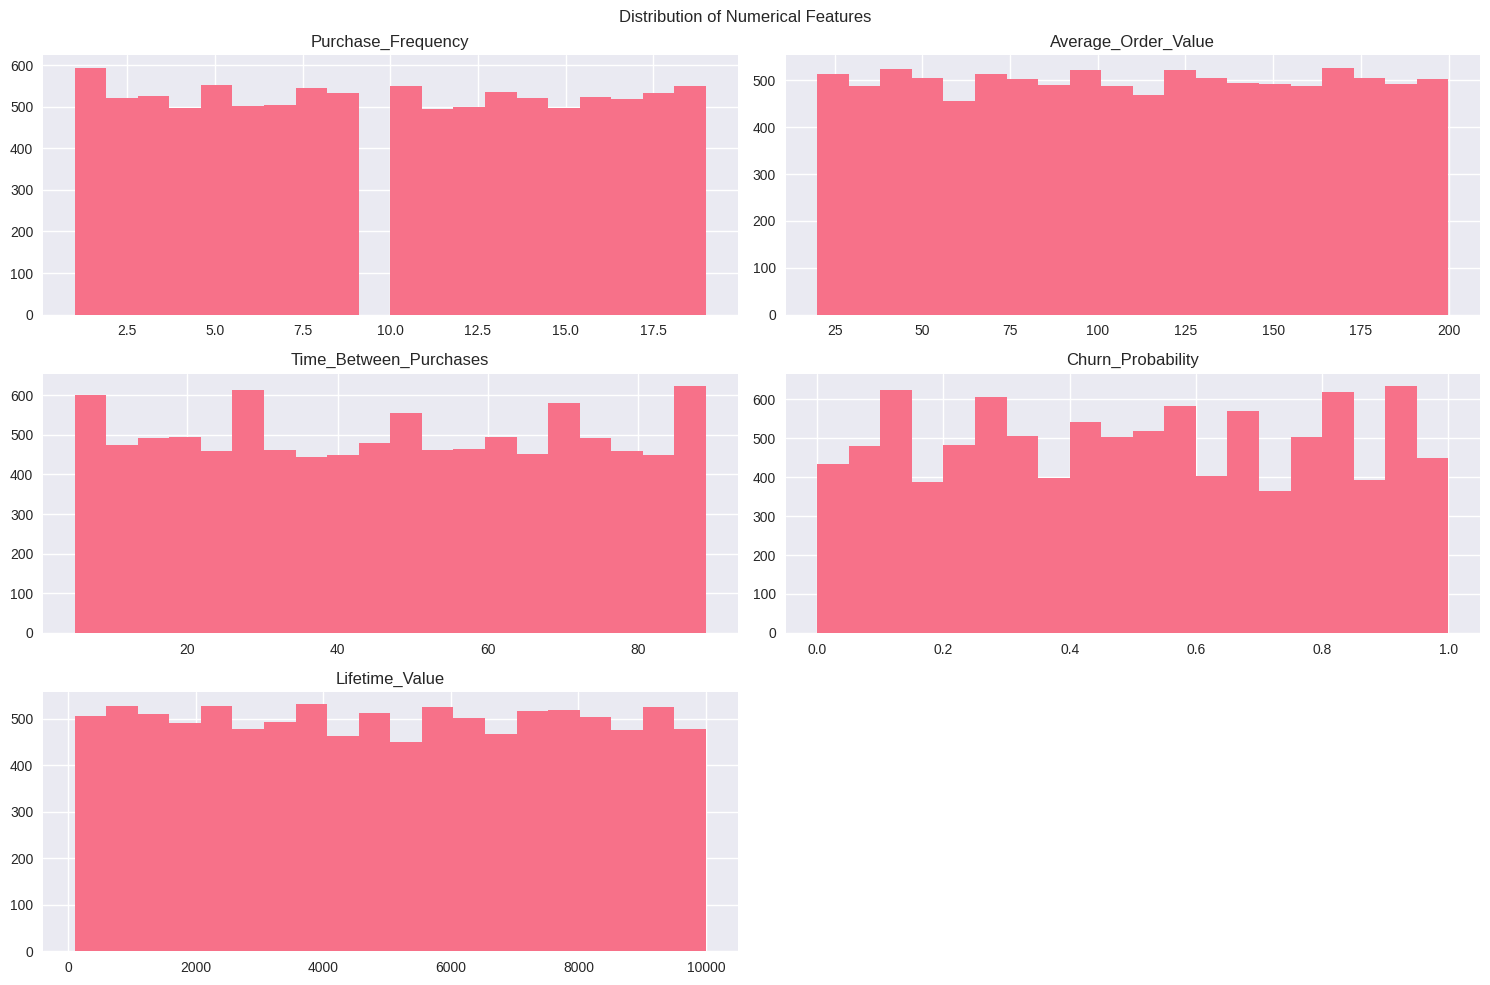

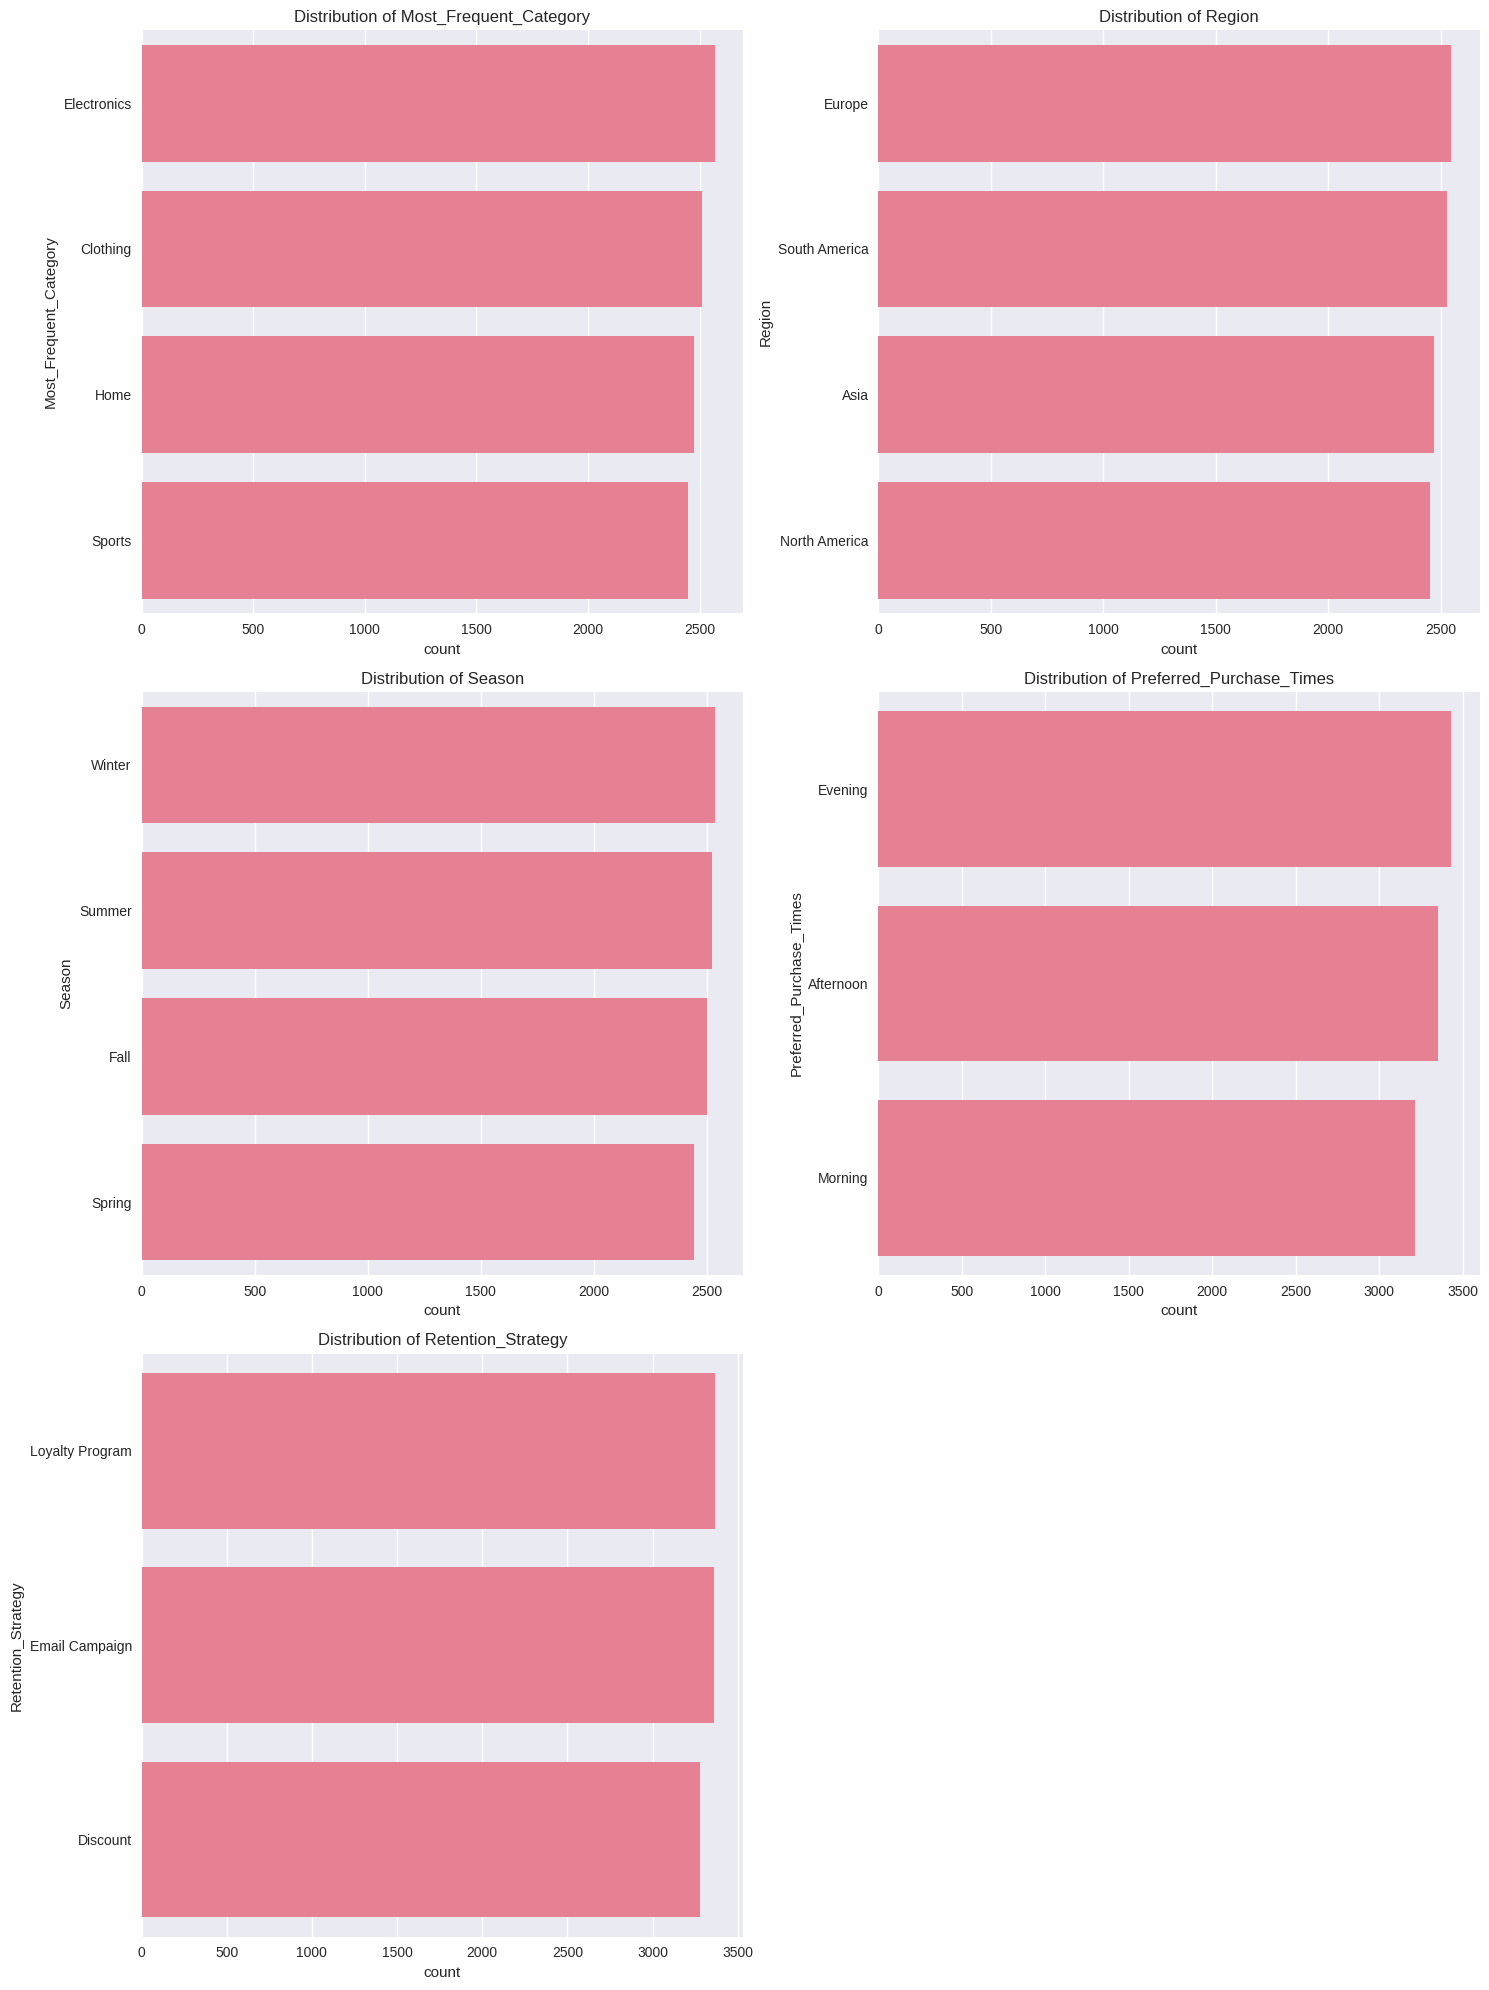

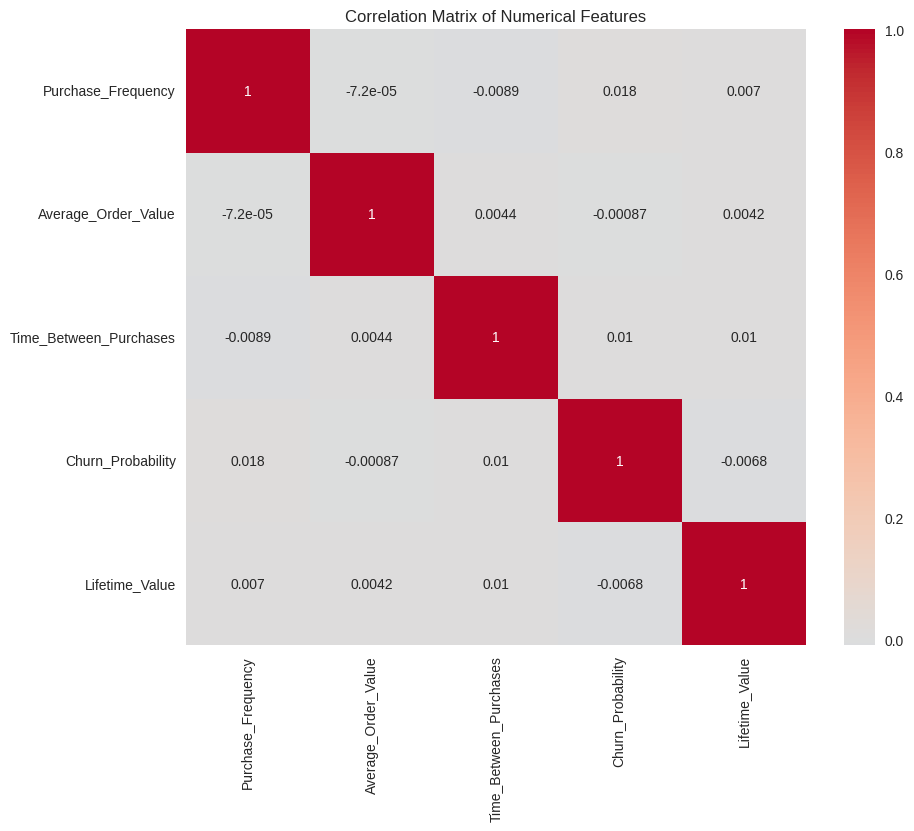

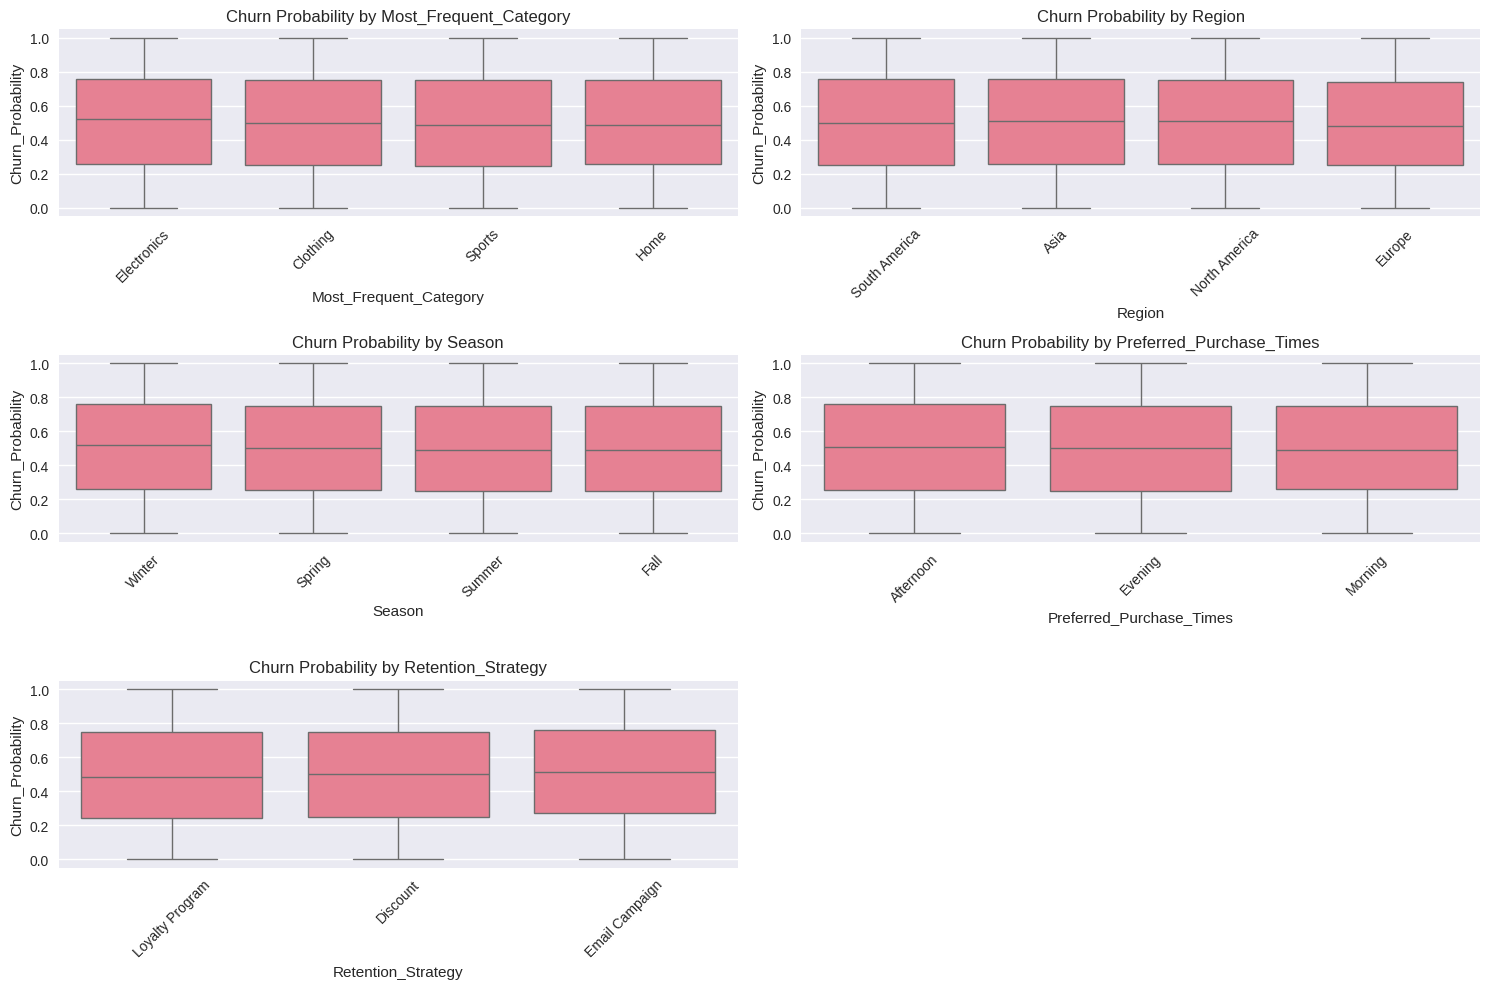

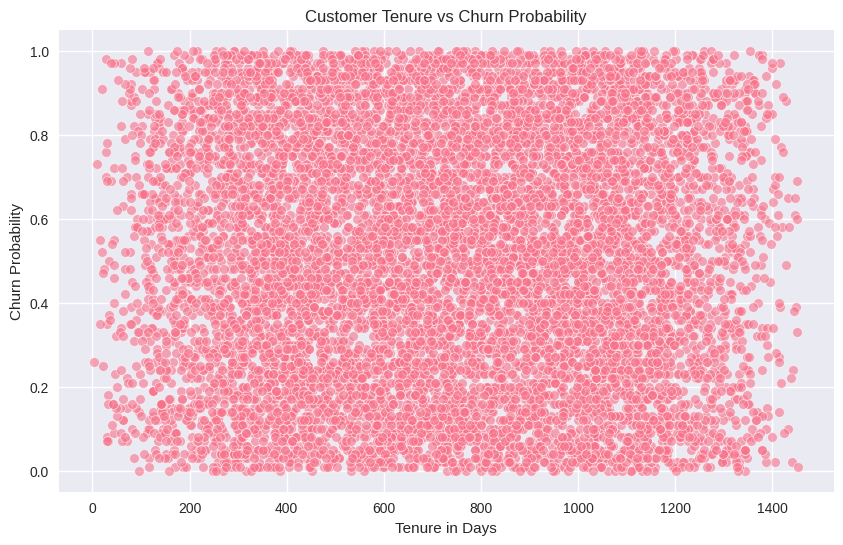

In [2]:
# Set up visualization style
plt.style.use('seaborn-v0_8')

sns.set_palette("husl")

# 1. Distribution of numerical features
num_cols = ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases',
            'Churn_Probability', 'Lifetime_Value']
df[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

# 2. Categorical features analysis
cat_cols = ['Most_Frequent_Category', 'Region', 'Season', 'Preferred_Purchase_Times',
            'Retention_Strategy']

plt.figure(figsize=(15, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

# 3. Correlation analysis
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# 4. Churn probability by categories
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, y='Churn_Probability')
    plt.title(f'Churn Probability by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

# 5. Time-based analysis
# Convert date columns to datetime
df['Launch_Date'] = pd.to_datetime(df['Launch_Date'])
df['Peak_Sales_Date'] = pd.to_datetime(df['Peak_Sales_Date'])

# Calculate customer tenure in days
df['Tenure_Days'] = (df['Peak_Sales_Date'] - df['Launch_Date']).dt.days

# Plot tenure vs churn probability
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Tenure_Days', y='Churn_Probability', alpha=0.6)
plt.title('Customer Tenure vs Churn Probability')
plt.xlabel('Tenure in Days')
plt.ylabel('Churn Probability')
plt.show()

In [3]:
# Feature engineering
def preprocess_data(df):
    # Create binary churn label based on threshold (let's say 0.5)
    df['Churn_Label'] = (df['Churn_Probability'] >= 0.5).astype(int)

    # Create customer segments based on RFM (Recency, Frequency, Monetary)
    # Recency - inverse of time between purchases (shorter time = more recent)
    df['Recency_Score'] = pd.qcut(df['Time_Between_Purchases'], q=5, labels=False)
    # Frequency - purchase frequency
    df['Frequency_Score'] = pd.qcut(df['Purchase_Frequency'], q=5, labels=False)
    # Monetary - average order value
    df['Monetary_Score'] = pd.qcut(df['Average_Order_Value'], q=5, labels=False)

    # Calculate RFM score
    df['RFM_Score'] = df['Recency_Score'] + df['Frequency_Score'] + df['Monetary_Score']

    # Time since last peak sales (assuming peak sales is last interaction)
    current_date = df['Peak_Sales_Date'].max()
    df['Days_Since_Last_Interaction'] = (current_date - df['Peak_Sales_Date']).dt.days

    # Preferred time of day to numerical
    time_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
    df['Preferred_Time_Encoded'] = df['Preferred_Purchase_Times'].map(time_mapping)

    # Season to numerical
    season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['Season_Encoded'] = df['Season'].map(season_mapping)

    return df

df = preprocess_data(df)

# Define features and target
X = df.drop(['Customer_ID', 'Product_ID', 'Transaction_ID', 'Launch_Date',
             'Peak_Sales_Date', 'Churn_Probability', 'Churn_Label'], axis=1)
y = df['Churn_Label']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing pipeline
numeric_features = ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases',
                   'Lifetime_Value', 'Tenure_Days', 'Recency_Score', 'Frequency_Score',
                   'Monetary_Score', 'RFM_Score', 'Days_Since_Last_Interaction',
                   'Preferred_Time_Encoded', 'Season_Encoded']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Most_Frequent_Category', 'Region', 'Retention_Strategy']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)


Random Forest Performance:
Accuracy: 0.4925
ROC AUC: 0.5050
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       992
           1       0.50      0.49      0.49      1008

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000


Gradient Boosting Performance:
Accuracy: 0.4815
ROC AUC: 0.4838
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.43      0.45       992
           1       0.49      0.54      0.51      1008

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000


Logistic Regression Performance:
Accuracy: 0.5065
ROC AUC: 0.5028
Classification Report:
              precision    recall  f1-score   support

           0       0.50      

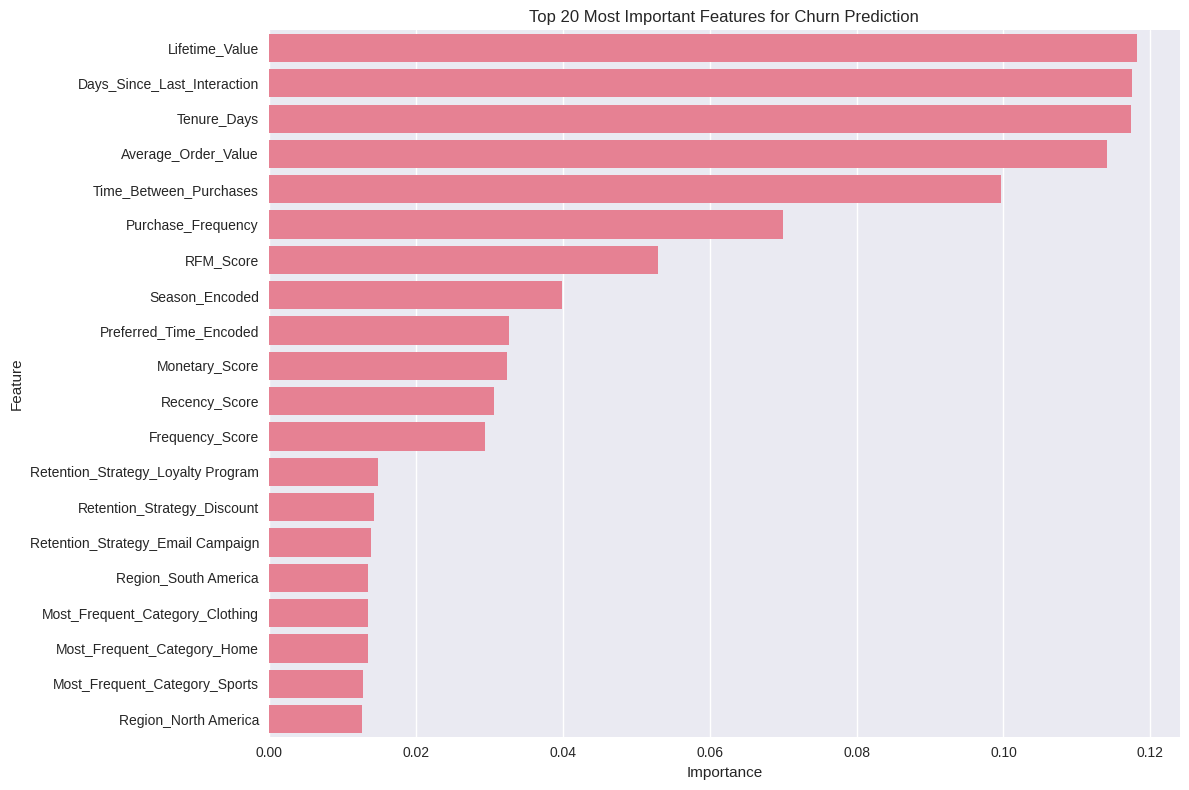

In [4]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Create pipeline
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'model': clf
    }

    # Print results
    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print("Classification Report:")
    print(results[name]['classification_report'])

# Select best model based on ROC AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Save the best model
joblib.dump(best_model, 'best_churn_model.pkl')

# Feature importance for the best model
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # For tree-based models
    feature_importances = best_model.named_steps['classifier'].feature_importances_

    # Get feature names after one-hot encoding
    ohe_features = best_model.named_steps['preprocessor'].named_transformers_['cat'] \
        .named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(ohe_features)

    # Create feature importance dataframe
    fi_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=fi_df.head(20), x='Importance', y='Feature')
    plt.title('Top 20 Most Important Features for Churn Prediction')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    # For logistic regression
    coefficients = best_model.named_steps['classifier'].coef_[0]

    # Get feature names
    ohe_features = best_model.named_steps['preprocessor'].named_transformers_['cat'] \
        .named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(ohe_features)

    # Create coefficient dataframe
    coef_df = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients
    }).sort_values('Coefficient', ascending=False)

    # Plot coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(data=coef_df.head(20), x='Coefficient', y='Feature')
    plt.title('Top 20 Most Predictive Features for Churn (Logistic Regression)')
    plt.tight_layout()
    plt.show()

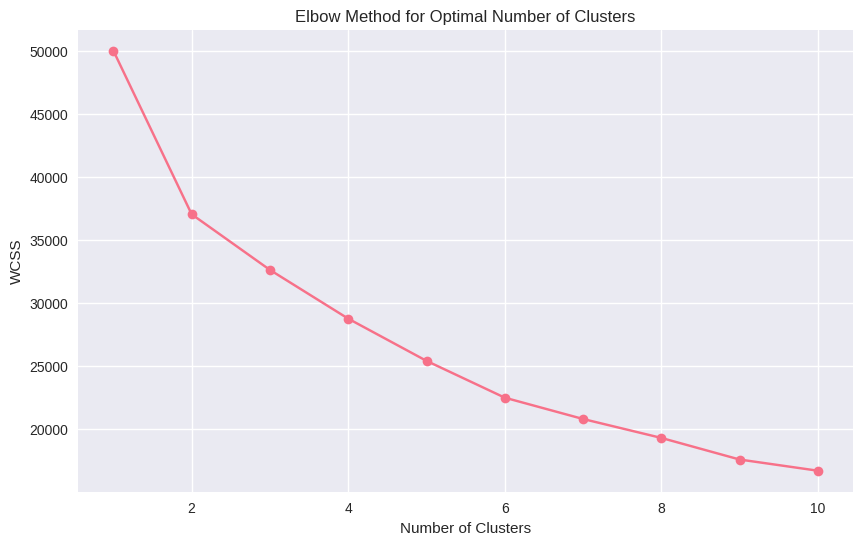


Segment Analysis:
         RFM_Score  Average_Order_Value  Purchase_Frequency  \
Segment                                                       
0         6.272727           116.590060            5.610082   
1         3.903498            89.821226            8.214496   
2         4.095667            90.316323            9.288717   
3         8.485378           136.397166           15.257479   

         Time_Between_Purchases  Churn_Probability  
Segment                                             
0                     69.984920           0.460849  
1                     29.851243           0.763430  
2                     28.561991           0.231720  
3                     56.807731           0.535842  


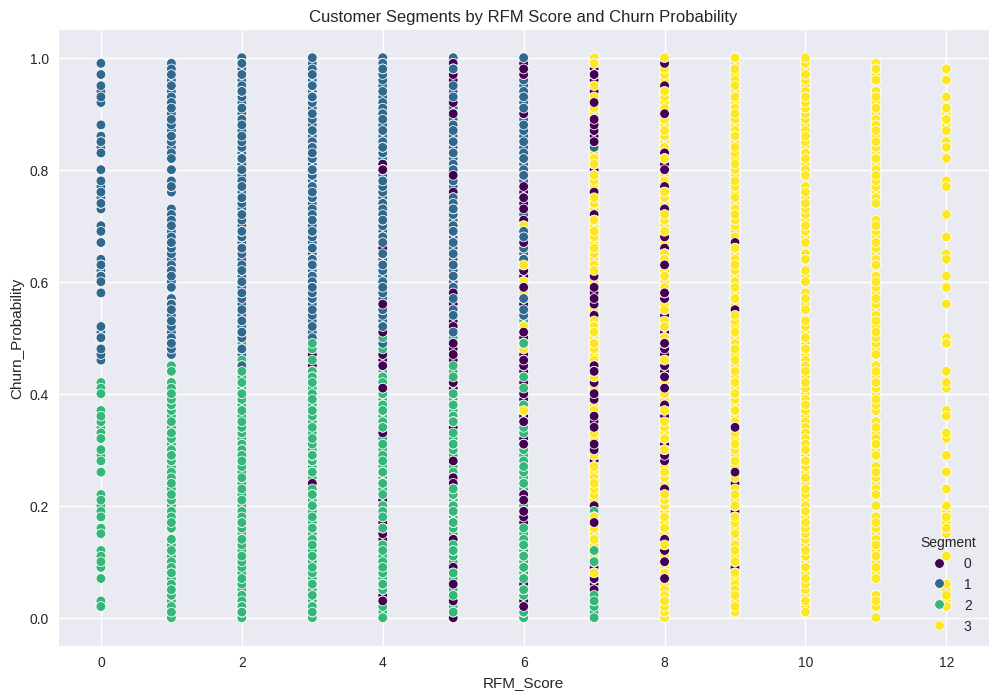

In [5]:
# Create features for segmentation
segmentation_features = ['RFM_Score', 'Average_Order_Value', 'Purchase_Frequency',
                        'Time_Between_Purchases', 'Churn_Probability']

# Standardize features
scaler = StandardScaler()
X_seg = scaler.fit_transform(df[segmentation_features])

# Determine optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_seg)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow plot, choose the number of clusters (let's say 4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Segment'] = kmeans.fit_predict(X_seg)

# Analyze segments
segment_analysis = df.groupby('Segment')[segmentation_features].mean()
print("\nSegment Analysis:")
print(segment_analysis)

# Visualize segments
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='RFM_Score', y='Churn_Probability', hue='Segment', palette='viridis')
plt.title('Customer Segments by RFM Score and Churn Probability')
plt.show()

In [6]:
def recommend_strategy(customer_data, model, threshold=0.5):
    """
    Recommends retention strategies based on customer data and predicted churn probability

    Args:
        customer_data: DataFrame containing customer features
        model: Trained churn prediction model
        threshold: Probability threshold to consider customer at risk

    Returns:
        DataFrame with original data plus predictions and recommendations
    """
    # Make predictions
    proba = model.predict_proba(customer_data)[:, 1]
    predictions = (proba >= threshold).astype(int)

    # Add predictions to customer data
    results = customer_data.copy()
    results['Predicted_Churn_Probability'] = proba
    results['Predicted_Churn'] = predictions

    # Create recommendations based on segments and features
    recommendations = []
    for _, row in results.iterrows():
        if row['Predicted_Churn'] == 1:
            # High churn risk customers
            if row['Average_Order_Value'] > df['Average_Order_Value'].median():
                # High value customers
                if row['Time_Between_Purchases'] > df['Time_Between_Purchases'].median():
                    rec = "Personalized high-value offer + VIP customer service"
                else:
                    rec = "Exclusive early access to new products + loyalty points bonus"
            else:
                # Lower value customers
                if row['Purchase_Frequency'] > df['Purchase_Frequency'].median():
                    rec = "Frequency-based discount + free shipping on next order"
                else:
                    rec = "Win-back offer + product recommendations based on browsing history"

            # Additional considerations
            if row['Most_Frequent_Category'] == 'Electronics':
                rec += " + Extended warranty offer"
            elif row['Most_Frequent_Category'] == 'Clothing':
                rec += " + Free return shipping"
        else:
            # Low churn risk customers
            rec = "Standard retention (newsletter, general promotions)"

        recommendations.append(rec)

    results['Recommended_Strategy'] = recommendations

    return results

# Test the recommendation system
sample_customers = X_test.sample(5, random_state=42)
recommendations = recommend_strategy(sample_customers, best_model)

print("\nSample Customer Retention Recommendations:")
print(recommendations[['Most_Frequent_Category', 'Average_Order_Value',
                      'Purchase_Frequency', 'Predicted_Churn_Probability',
                      'Recommended_Strategy']])


Sample Customer Retention Recommendations:
     Most_Frequent_Category  Average_Order_Value  Purchase_Frequency  \
2369                   Home               173.37                   3   
7261            Electronics               163.76                  14   
3145                   Home               128.88                   3   
2840            Electronics                97.64                   4   
1868               Clothing                42.51                  14   

      Predicted_Churn_Probability  \
2369                         0.60   
7261                         0.66   
3145                         0.44   
2840                         0.50   
1868                         0.54   

                                   Recommended_Strategy  
2369  Exclusive early access to new products + loyal...  
7261  Exclusive early access to new products + loyal...  
3145  Standard retention (newsletter, general promot...  
2840  Win-back offer + product recommendations based...  
1868  Freq


Business Impact Simulation Results:
At_Risk_Customers: 5,031.00
Potential_Saved_Customers: 2,515.00
Average_CLTV_At_Risk: 4,992.39
Total_Value_Saved: 12,555,863.84
CAC_Savings: 1,936,656.02
Implementation_Cost: 50,000.00
NPV: 13,125,018.05
ROI_Percentage: 28,885.04


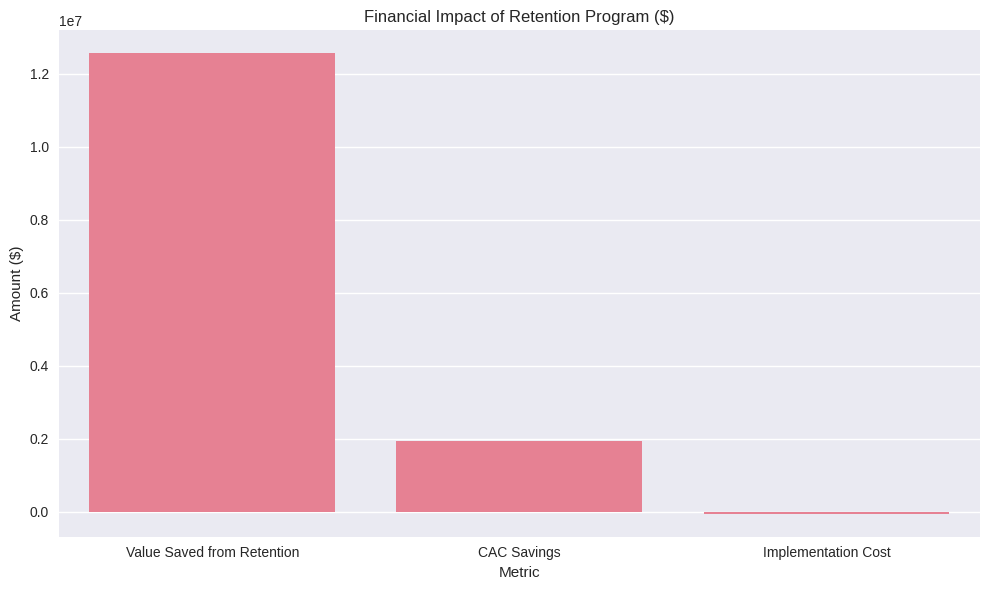

In [7]:
def simulate_business_impact(df, model, implementation_cost=50000, discount_rate=0.1):
    """
    Simulates the business impact of implementing the retention strategies

    Args:
        df: Full dataset
        model: Trained churn prediction model
        implementation_cost: Cost to implement the retention program
        discount_rate: Discount rate for future cash flows

    Returns:
        Dictionary with various business impact metrics
    """
    # Predict churn for all customers
    df['Predicted_Churn_Probability'] = model.predict_proba(df.drop(
        ['Customer_ID', 'Product_ID', 'Transaction_ID', 'Launch_Date',
         'Peak_Sales_Date', 'Churn_Probability', 'Churn_Label', 'Segment'], axis=1))[:, 1]

    # Assume we can save 50% of at-risk customers (those with predicted probability > 0.5)
    at_risk = df[df['Predicted_Churn_Probability'] > 0.5]
    saved_customers = int(len(at_risk) * 0.5)

    # Calculate average CLTV of at-risk customers
    avg_cltv_at_risk = at_risk['Lifetime_Value'].mean()

    # Total value saved
    total_value_saved = saved_customers * avg_cltv_at_risk

    # Calculate CAC savings (assuming we would have to acquire new customers to replace churned ones)
    # Average CAC is typically 5-10x the average order value
    avg_cac = df['Average_Order_Value'].mean() * 7
    cac_savings = saved_customers * avg_cac

    # Calculate NPV of the program
    npv = (total_value_saved + cac_savings) / (1 + discount_rate) - implementation_cost

    # Calculate ROI
    roi = ((total_value_saved + cac_savings - implementation_cost) / implementation_cost) * 100

    return {
        'At_Risk_Customers': len(at_risk),
        'Potential_Saved_Customers': saved_customers,
        'Average_CLTV_At_Risk': avg_cltv_at_risk,
        'Total_Value_Saved': total_value_saved,
        'CAC_Savings': cac_savings,
        'Implementation_Cost': implementation_cost,
        'NPV': npv,
        'ROI_Percentage': roi
    }

# Run simulation
impact = simulate_business_impact(df, best_model)

print("\nBusiness Impact Simulation Results:")
for k, v in impact.items():
    print(f"{k}: {v:,.2f}" if isinstance(v, (int, float)) else f"{k}: {v}")

# Visualization of impact
impact_df = pd.DataFrame({
    'Metric': ['Value Saved from Retention', 'CAC Savings', 'Implementation Cost'],
    'Amount': [impact['Total_Value_Saved'], impact['CAC_Savings'], -impact['Implementation_Cost']]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=impact_df, x='Metric', y='Amount')
plt.title('Financial Impact of Retention Program ($)')
plt.ylabel('Amount ($)')
plt.tight_layout()
plt.show()

In [8]:
# Create a function to generate deployment plan
def generate_deployment_plan():
    plan = """
    Deployment and Monitoring Plan for Customer Retention System:

    1. Phased Implementation:
       - Phase 1 (Weeks 1-2): Deploy churn prediction model in test environment
       - Phase 2 (Weeks 3-4): Pilot retention strategies with 10% of at-risk customers
       - Phase 3 (Weeks 5-6): Full deployment with all at-risk customers

    2. Integration Points:
       - CRM System: Feed churn predictions and recommendations to sales/support teams
       - Email Marketing Platform: Automate personalized retention campaigns
       - Customer Service Dashboard: Highlight at-risk customers during interactions

    3. Monitoring Framework:
       - Daily: Track number of at-risk customers identified
       - Weekly: Monitor response rates to retention strategies
       - Monthly: Calculate actual vs predicted churn rates
       - Quarterly: Re-train model with new data and evaluate performance

    4. Key Performance Indicators (KPIs):
       - Reduction in churn rate (target: 20-30% reduction in 6 months)
       - Increase in repeat purchase rate (target: 15% increase in 6 months)
       - ROI of retention program (target: 3x return in first year)
       - Customer satisfaction scores for retained customers

    5. Continuous Improvement:
       - A/B test different retention strategies
       - Collect feedback from saved customers
       - Regularly update model features based on new data patterns
    """
    return plan

print(generate_deployment_plan())


    Deployment and Monitoring Plan for Customer Retention System:
    
    1. Phased Implementation:
       - Phase 1 (Weeks 1-2): Deploy churn prediction model in test environment
       - Phase 2 (Weeks 3-4): Pilot retention strategies with 10% of at-risk customers
       - Phase 3 (Weeks 5-6): Full deployment with all at-risk customers
    
    2. Integration Points:
       - CRM System: Feed churn predictions and recommendations to sales/support teams
       - Email Marketing Platform: Automate personalized retention campaigns
       - Customer Service Dashboard: Highlight at-risk customers during interactions
    
    3. Monitoring Framework:
       - Daily: Track number of at-risk customers identified
       - Weekly: Monitor response rates to retention strategies
       - Monthly: Calculate actual vs predicted churn rates
       - Quarterly: Re-train model with new data and evaluate performance
    
    4. Key Performance Indicators (KPIs):
       - Reduction in churn rate (tar

In [9]:
# Final recommendations and next steps
conclusion = """
Project Conclusion and Next Steps:

1. Key Findings:
   - Identified {:.1f}% of customers as high churn risk
   - Top factors influencing churn: {}
   - Most effective retention strategies vary by customer segment

2. Immediate Actions:
   - Implement the churn prediction system
   - Begin targeted retention campaigns for highest-risk segments
   - Train customer service teams on identified at-risk customers

3. Long-Term Recommendations:
   - Build a closed-loop system where strategy effectiveness feeds back into the model
   - Expand data collection to include customer service interactions and product reviews
   - Develop a customer health score combining churn risk and potential value

4. Future Enhancements:
   - Incorporate real-time behavioral data from website/app
   - Add natural language processing of customer service interactions
   - Develop dynamic pricing/promotion engine for at-risk customers
""".format(
    len(df[df['Predicted_Churn_Probability'] > 0.5]) / len(df) * 100,
    ', '.join(fi_df.head(3)['Feature'].tolist() if 'fi_df' in locals() else "RFM Score, Lifetime Value, Purchase Frequency")
)

print(conclusion)


Project Conclusion and Next Steps:

1. Key Findings:
   - Identified 50.3% of customers as high churn risk
   - Top factors influencing churn: Lifetime_Value, Days_Since_Last_Interaction, Tenure_Days
   - Most effective retention strategies vary by customer segment

2. Immediate Actions:
   - Implement the churn prediction system
   - Begin targeted retention campaigns for highest-risk segments
   - Train customer service teams on identified at-risk customers

3. Long-Term Recommendations:
   - Build a closed-loop system where strategy effectiveness feeds back into the model
   - Expand data collection to include customer service interactions and product reviews
   - Develop a customer health score combining churn risk and potential value

4. Future Enhancements:
   - Incorporate real-time behavioral data from website/app
   - Add natural language processing of customer service interactions
   - Develop dynamic pricing/promotion engine for at-risk customers

